In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Data ingestion

In [32]:
data = pd.read_csv('../data/HR-Analytics.csv')

In [33]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,age
0,0.24,0.79,2,175,5,0,0,0,IT,low,NaN
1,0.40,0.49,2,155,3,0,1,0,hr,medium,27.0
2,0.45,0.45,2,154,3,1,1,0,support,medium,NaN
3,0.46,0.73,6,256,4,0,0,0,product_mng,high,NaN
4,0.14,0.54,5,275,4,1,0,0,sales,high,NaN


In [34]:
data.shape

(15004, 11)

### Handling Missing Values

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15004 entries, 0 to 15003
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     15004 non-null  float64
 1   last_evaluation        15004 non-null  float64
 2   number_project         15004 non-null  int64  
 3   average_montly_hours   15004 non-null  int64  
 4   time_spend_company     15004 non-null  int64  
 5   Work_accident          15004 non-null  int64  
 6   left                   15004 non-null  object 
 7   promotion_last_5years  15004 non-null  int64  
 8   Department             15004 non-null  object 
 9   salary                 14975 non-null  object 
 10  age                    3080 non-null   float64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.3+ MB


### The target column is left.

In [36]:
data.left.unique()

array(['0', '1', '?'], dtype=object)

In [37]:
# to see count of each unique values out of 15004 entries
data.left.value_counts()

left
0    11428
1     3572
?        4
Name: count, dtype: int64

### Since left has to have either 0 or 1 we have to remove '?'

In [38]:
data.replace(['?',"","n/a","-","--"],np.nan,inplace=True)

In [39]:
data.left.unique()

array(['0', '1', nan], dtype=object)

In [40]:
# Check the null values
data.isna().sum()

satisfaction_level           0
last_evaluation              0
number_project               0
average_montly_hours         0
time_spend_company           0
Work_accident                0
left                         4
promotion_last_5years        0
Department                   0
salary                      29
age                      11924
dtype: int64

### Here, left contained 4 '?' values and it was replaced by nan, thus sum of nan values in left column is 4 

### SInce there are null values in target, we will drop the corresponding row to handle the missing data.

In [41]:
data.dropna(subset=['left'], inplace=True)

In [42]:
data.left.unique()

array(['0', '1'], dtype=object)

### Since age column has more than 70% data missing, we drip the entire age column.

In [43]:
data.drop(columns=['age'], axis='column', inplace=True)

In [44]:
data.shape

(15000, 10)

In [45]:
data.salary.value_counts()

salary
low       7287
medium    6447
high      1237
Name: count, dtype: int64

In [46]:
data.salary.fillna(data.salary.mode().values[0], inplace=True)

In [47]:
data.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

### Data exploration

<AxesSubplot:xlabel='left', ylabel='count'>

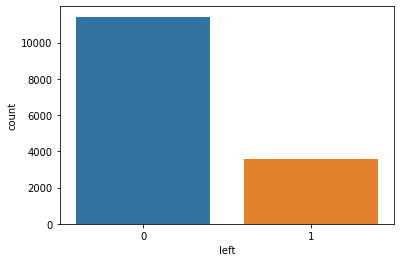

In [48]:
# countplot over target variable
sns.countplot(x="left", data=data)

### Since the dataset is imbalanced, we use precision or recall not accuracy.

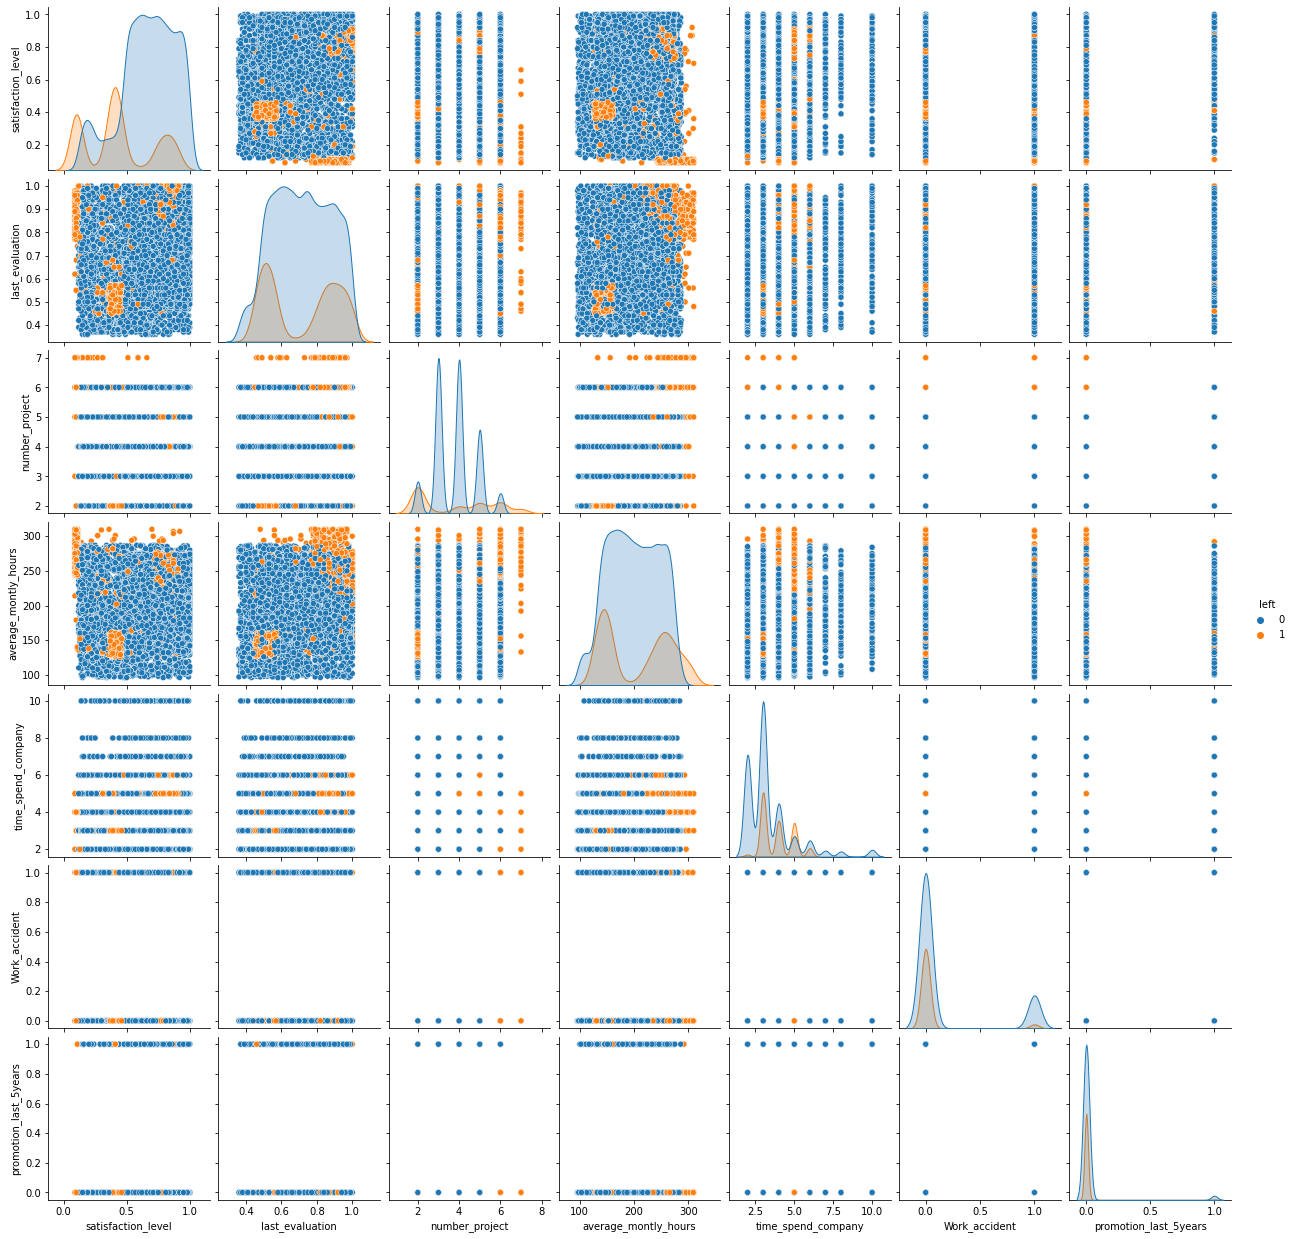

In [49]:
# Pairplot over the target variable
sns.pairplot(data, hue='left')

### Impact of salary on employee retention

<AxesSubplot:xlabel='salary', ylabel='count'>

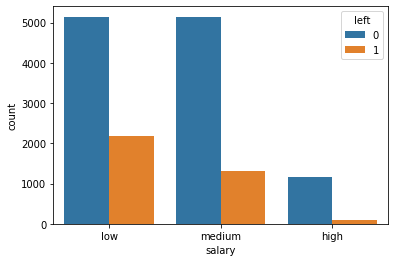

In [23]:
sns.countplot(x='salary', hue='left', data=data)

### Impact of department on employee retention

<AxesSubplot:xlabel='Department', ylabel='count'>

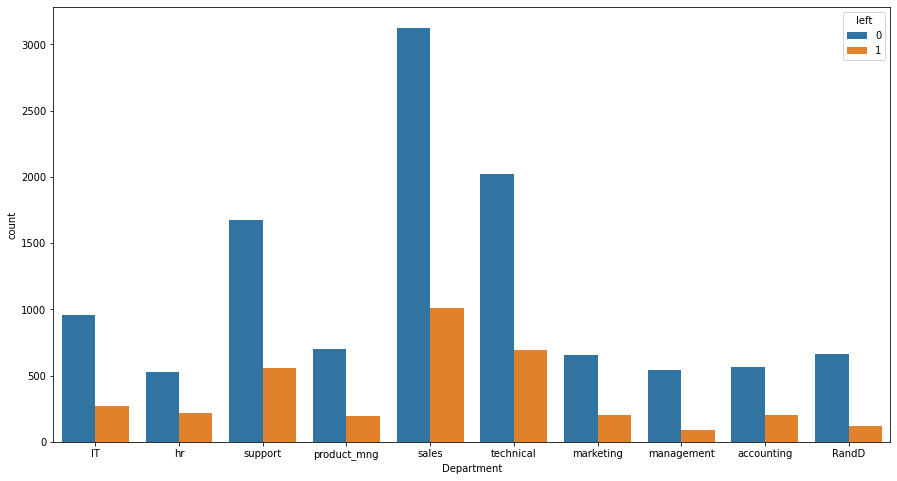

In [31]:
plt.figure(figsize=(15,8))
sns.countplot(x='Department', hue='left', data=data)

### Impact of projects on employee retention

<AxesSubplot:xlabel='number_project', ylabel='count'>

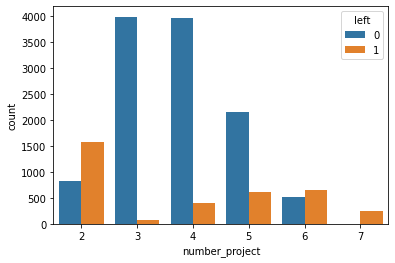

In [28]:
sns.countplot(x='number_project', hue='left', data=data)

<AxesSubplot:xlabel='average_montly_hours', ylabel='count'>

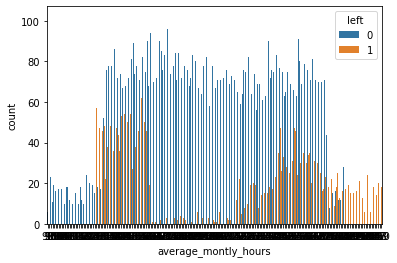

In [32]:
sns.countplot(x='average_montly_hours', hue='left', data=data)

<AxesSubplot:xlabel='time_spend_company', ylabel='count'>

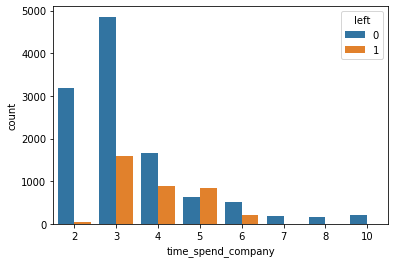

In [33]:
sns.countplot(x='time_spend_company', hue='left', data=data)

<AxesSubplot:xlabel='promotion_last_5years', ylabel='count'>

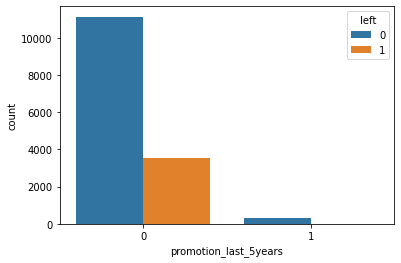

In [34]:
sns.countplot(x='promotion_last_5years', hue='left', data=data)

<AxesSubplot:xlabel='satisfaction_level', ylabel='count'>

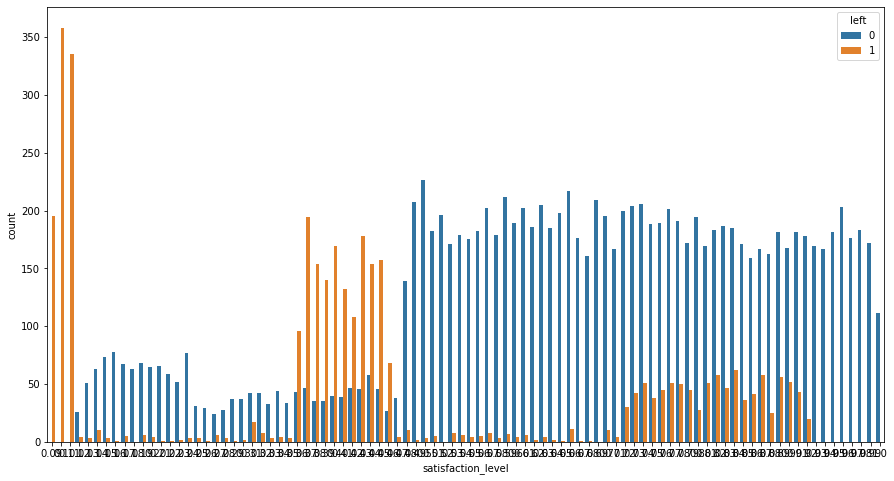

In [36]:
plt.figure(figsize=(15,8))
sns.countplot(x='satisfaction_level', hue='left', data=data)

### From the data exploration, it is seen that the features like satisfaction level, salary, time spent at company, number of projects, promotion in last 5 years are taken as independent variables.

In [50]:
data = data[['satisfaction_level','average_montly_hours','number_project','time_spend_company','salary','left']]
data.head()

,satisfaction_level,average_montly_hours,number_project,time_spend_company,salary,left
0,0.24,175,2,5,low,0
1,0.40,155,2,3,medium,1
2,0.45,154,2,3,medium,1
3,0.46,256,6,4,high,0
4,0.14,275,5,4,high,0


### Here, since salary is categorial value, we must convert it into the numerical for further machine learning process.

In [51]:
salary = pd.get_dummies(data['salary'])
salary.head()

,high,low,medium
0,False,True,False
1,False,False,True
2,False,False,True
3,True,False,False
4,True,False,False


In [52]:
salary = pd.get_dummies(data['salary'], dtype='int')
data = pd.concat([data,salary], axis='columns')
data.head()

,satisfaction_level,average_montly_hours,number_project,time_spend_company,salary,left,high,low,medium
0,0.24,175,2,5,low,0,0,1,0
1,0.40,155,2,3,medium,1,0,0,1
2,0.45,154,2,3,medium,1,0,0,1
3,0.46,256,6,4,high,0,1,0,0
4,0.14,275,5,4,high,0,1,0,0


In [53]:
data.drop(['salary'], axis=1, inplace=True)
data.head()

,satisfaction_level,average_montly_hours,number_project,time_spend_company,left,high,low,medium
0,0.24,175,2,5,0,0,1,0
1,0.40,155,2,3,1,0,0,1
2,0.45,154,2,3,1,0,0,1
3,0.46,256,6,4,0,1,0,0
4,0.14,275,5,4,0,1,0,0


### Training and testing model

In [54]:
x = data.drop('left', axis=1)
y = data['left']

In [55]:
x.head()

,satisfaction_level,average_montly_hours,number_project,time_spend_company,high,low,medium
0,0.24,175,2,5,0,1,0
1,0.40,155,2,3,0,0,1
2,0.45,154,2,3,0,0,1
3,0.46,256,6,4,1,0,0
4,0.14,275,5,4,1,0,0


In [56]:
y.head()

0    0
1    1
2    1
3    0
4    0
Name: left, dtype: object

### Here x represents the training attributes while y consists target variable.

## Train-test split data

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### To free up some memory, deleting the intermediate variables

In [58]:
del data, salary, x, y

### Train and evaluate function

In [59]:
def train(x_train, y_train, model, hyperparameters):
    """
    Arguments:
    x_train -- input features of the training set
    y_train -- target values of the training set
    model -- an instance of the model class (e.g. LogisticRegression, Knn, etc.)
    hyperparameters -- dictionary of list of hyperparameter values
    
    Returns:
    best_params -- dictionary of best hyperparameters found
    best_model -- an instance of the model class with tuned hyperparameters
    """
    
    #perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=5)
    grid_search.fit(x_train, y_train)
    
    # Print the best hyperparameters found
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Train the model with best hyperparameters
    best_model = model.set_params(**best_params)
    best_model.fit(x_train, y_train)
    
    return best_params, best_model

In [26]:
def evaluate_model(x_test, y_test, best_model):
    """
    Arguments:
    best model -- an instance of the model class with tuned hyperparameters
    x_test -- input features of the test set
    y_test -- target values of the test set
    
    Returns:
    accuracy -- accuracy score on the test set
    precision -- precision score on the test set
    recall -- recall score on the test set
    f1_score -- f1 score on the test set
    """
    # Predict the target values of the test set
    y_pred = best_model.predict(x_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='1')
    recall = recall_score(y_test, y_pred, pos_label='1')
    f1 = f1_score(y_test, y_pred, pos_label='1')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    
    return accuracy, precision, recall, f1

### K-Nearest Neighbors (KNN)

In [64]:
hyperparameters = {
    'n_neighbors' : [3,6,7,9,11,13],
    'weights' : ['uniform', 'distance'],
}

model = KNeighborsClassifier()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'n_neighbors': 6, 'weights': 'distance'}
Accuracy: 0.9613333333333334
Precision: 0.8783958602846055
Recall: 0.9686162624821684
F1 score: 0.921302578018996


### Naive bayes classifier

In [66]:
hyperparameters = {
    'var_smoothing': [10**(-x) for x in range(1, 11)]
}
model = GaussianNB()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'var_smoothing': 1e-05}
Accuracy: 0.8346666666666667
Precision: 0.6788830715532286
Recall: 0.5549215406562055
F1 score: 0.6106750392464678


### Logistic regression

In [67]:
hyperparameters = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1','l2'],
    'solver': ['liblinear']
}
model = LogisticRegression()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7833333333333333
Precision: 0.5962264150943396
Recall: 0.2253922967189729
F1 score: 0.32712215320910976


### Decision Tree classifier

In [68]:
hyperparameters = {
    'max_depth': [3,5,7,9],
    'min_samples_split': [2,5,10]
}

model = DecisionTreeClassifier()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'max_depth': 9, 'min_samples_split': 2}
Accuracy: 0.9756666666666667
Precision: 0.974320241691843
Recall: 0.920114122681883
F1 score: 0.946441672780631


### Random forest classifier

In [69]:
hyperparameters = {
    'n_estimators':[100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

model = RandomForestClassifier()
_, best_model = train(x_train, y_train, model, hyperparameters)
scores = evaluate_model(x_test, y_test, best_model)

Best Hyperparameters: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.978
Precision: 0.9847328244274809
Recall: 0.920114122681883
F1 score: 0.9513274336283186
